# Marketing Mix Modeling (MMM) with Mediation Assumption

**Assessment 2 - MMM Modeling with Mediation Assumption**.

**What it includes:**

- Clean, well-documented code following good coding standards.
- EDA, feature engineering, baseline model, mediation-aware two-stage model.
- Time-series-aware cross-validation, diagnostics, and recommendations.

Replace dataset paths and tweak hyperparameters where necessary. Save results and export figures as needed.


## 0. Notes before running

- Place your dataset as `marketing_data.csv` in the same directory as this notebook, or update the path in the data-loading cell.
- If your data is embedded in a different file format (Excel, .xlsx, or provided PDF), extract it to CSV first.
- This notebook uses scikit-learn, pandas, numpy, matplotlib. Install required packages if missing:

```bash
pip install -U scikit-learn pandas numpy matplotlib seaborn xgboost nbformat joblib statsmodels
```


In [5]:
# 1. Imports and global configuration
import os
import warnings
from typing import Tuple, List, Dict, Any

warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

# Optional: XGBoost (uncomment if installed)
# from xgboost import XGBRegressor

# Global plotting style
plt.rcParams['figure.figsize'] = (10, 5)
sns.set(style='whitegrid')

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


## 1. Utility functions
Helper functions for reproducibility, evaluation, and plotting.

In [6]:
def rmse(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """Root mean squared error."""
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))


def evaluate_ts_model(model, X_train, y_train, X_test, y_test) -> Dict[str, float]:
    """Fit model and return evaluation metrics."""
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    return {
        'rmse': rmse(y_test, preds),
        'r2': float(r2_score(y_test, preds)),
        'mape': float(mean_absolute_percentage_error(y_test, preds))
    }


def time_series_cv_eval(model, X: pd.DataFrame, y: pd.Series, n_splits: int = 5) -> Dict[str, float]:
    """Perform time-series split CV and return mean metrics."""
    tscv = TimeSeriesSplit(n_splits=n_splits)
    metrics = {'rmse': [], 'r2': [], 'mape': []}

    for train_idx, test_idx in tscv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        metrics['rmse'].append(rmse(y_test, preds))
        metrics['r2'].append(float(r2_score(y_test, preds)))
        metrics['mape'].append(float(mean_absolute_percentage_error(y_test, preds)))

    return {k: float(np.mean(v)) for k, v in metrics.items()}


## 2. Load data
Update the path if necessary. The code handles CSV and Excel. If your dataset is in PDF, export to CSV first.

In [7]:
def load_marketing_data(path: str) -> pd.DataFrame:
    """Load marketing dataset from CSV or Excel into a DataFrame.

    Args:
        path: Path to CSV or Excel file.
    Returns:
        DataFrame with a parsed datetime index (if a Week/Date column exists).
    """
    if path.lower().endswith('.csv'):
        df = pd.read_csv(path)
    elif path.lower().endswith(('.xls', '.xlsx')):
        df = pd.read_excel(path)
    else:
        raise ValueError('Unsupported file type. Please provide a CSV or Excel file.')

    # Try to detect a Week or Date column
    date_cols = [c for c in df.columns if 'date' in c.lower() or 'week' in c.lower()]
    if date_cols:
        col = date_cols[0]
        try:
            df['ds'] = pd.to_datetime(df[col])
            df = df.sort_values('ds').reset_index(drop=True)
        except Exception:
            pass

    return df


# Example: change this to your actual filename
DATA_PATH = 'D:\Assessment2\Assessment 2 - MMM Weekly.csv\Assessment 2 - MMM Weekly.csv'

# If the user has not provided a CSV, we create an empty template file for them to fill.
if not os.path.exists(DATA_PATH):
    print(f"Warning: {DATA_PATH} not found. Creating a template CSV at that path.\n"
          "Please replace it with your real data and rerun the notebook.")
    # Create a template with common column names expected by the assessment
    template = pd.DataFrame({
        'Week': pd.date_range(start='2023-01-01', periods=104, freq='W'),
        'Revenue': np.nan,
        'Google_Spend': np.nan,
        'Facebook_Spend': np.nan,
        'TikTok_Spend': np.nan,
        'Snap_Spend': np.nan,
        'Email_Sent': np.nan,
        'Price': np.nan,
        'Followers': np.nan,
        'Promotions': np.nan
    })
    template.to_csv(DATA_PATH, index=False)

# Load (or reload) data
try:
    df = load_marketing_data(DATA_PATH)
    print('Data loaded. Shape:', df.shape)
except Exception as e:
    print('Error loading data:', e)
    df = pd.DataFrame()

# Show head
df.head()


Data loaded. Shape: (104, 13)


,week,facebook_spend,google_spend,tiktok_spend,instagram_spend,snapchat_spend,social_followers,average_price,promotions,emails_send,sms_send,revenue,ds
0,2023-09-17,6030.80,3130.14,2993.22,1841.08,2204.72,0,101.95,0,102684,20098,83124.16,2023-09-17
1,2023-09-24,5241.44,2704.00,0.00,0.00,0.00,0,103.86,0,96573,29920,373.02,2023-09-24
2,2023-10-01,5893.00,0.00,0.00,0.00,0.00,0,100.38,0,96797,22304,513.01,2023-10-01
3,2023-10-08,7167.16,0.00,0.00,0.00,0.00,0,103.14,1,99098,14171,452.78,2023-10-08
4,2023-10-15,5360.29,0.00,0.00,3237.15,0.00,0,107.76,1,120754,30207,41441.95,2023-10-15


## 3. Exploratory Data Analysis (EDA)
Look at trends, distributions, and correlations.

,week,facebook_spend,google_spend,tiktok_spend,instagram_spend,snapchat_spend,social_followers,average_price,promotions,emails_send,sms_send,revenue,ds
count,104,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104
unique,104,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,2023-09-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,5346.302500,1543.866442,955.632212,1019.342885,747.465000,72414.509615,99.962500,0.211538,120691.067308,23623.115385,49053.945096,2024-09-11 12:00:00
min,NaN,2456.940000,0.000000,0.000000,0.000000,0.000000,0.000000,87.560000,0.000000,68655.000000,10460.000000,1.000000,2023-09-17 00:00:00
25%,NaN,4538.977500,0.000000,0.000000,0.000000,0.000000,38318.250000,94.207500,0.000000,102971.500000,19252.500000,474.852500,2024-03-15 06:00:00
50%,NaN,5293.780000,0.000000,0.000000,0.000000,0.000000,81109.500000,99.490000,0.000000,120237.000000,22459.500000,972.065000,2024-09-11 12:00:00
75%,NaN,6033.325000,3374.205000,2487.172500,2395.350000,1705.872500,110281.250000,105.395000,0.000000,136594.000000,28107.000000,45773.732500,2025-03-10 18:00:00
max,NaN,9325.180000,6083.160000,4143.250000,3877.990000,3126.040000,143477.000000,113.380000,1.000000,185460.000000,40153.000000,398453.530000,2025-09-07 00:00:00


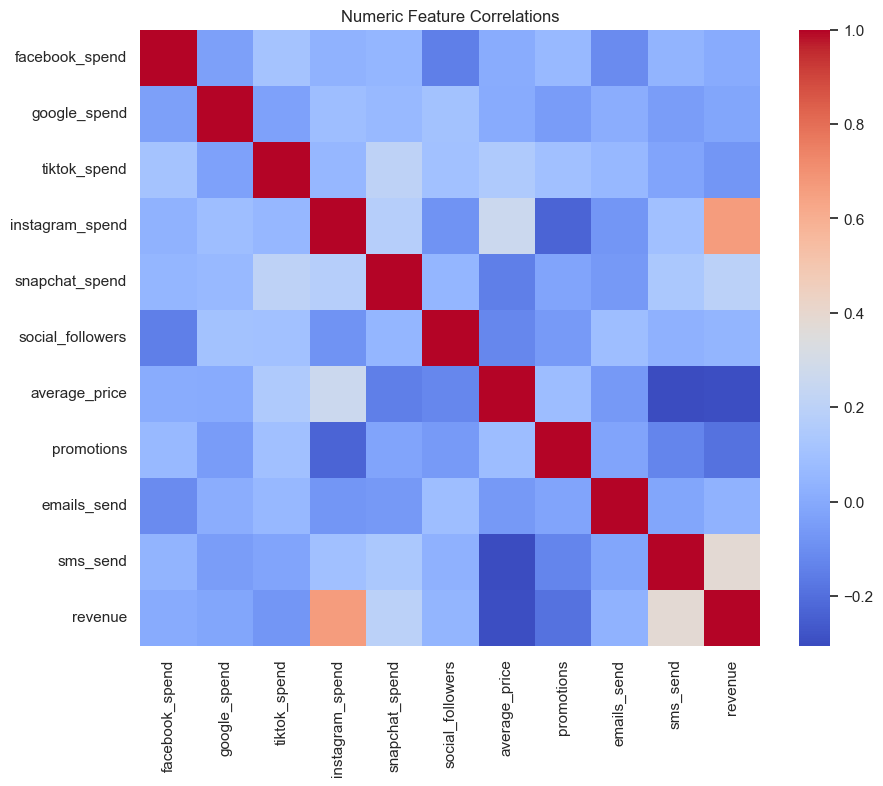

In [8]:
# EDA: basic checks (won't error if df is empty)
if not df.empty:
    display(df.describe(include='all'))

    # Plot revenue trend if available
    if 'Revenue' in df.columns:
        plt.figure()
        if 'ds' in df.columns:
            plt.plot(df['ds'], df['Revenue'])
            plt.xlabel('Date')
        else:
            plt.plot(df['Revenue'])
            plt.xlabel('Index')
        plt.ylabel('Revenue')
        plt.title('Revenue over Time')
        plt.show()

    # Correlation heatmap for numeric columns
    numeric = df.select_dtypes(include=[np.number])
    if not numeric.empty:
        plt.figure(figsize=(10, 8))
        sns.heatmap(numeric.corr(), annot=False, cmap='coolwarm')
        plt.title('Numeric Feature Correlations')
        plt.show()
else:
    print('Dataframe is empty — load your CSV into', DATA_PATH)


## 4. Feature engineering
Create lag features, log transforms, weekly seasonality features, and any indicators for zero-spend weeks.

In [9]:
def prepare_features(df: pd.DataFrame) -> pd.DataFrame:
    """Prepare features for modeling. Returns a new DataFrame with engineered features.

    Important: this function avoids look-ahead by using only past information for lag features.
    """
    df = df.copy()

    # Ensure datetime index if 'ds' exists
    if 'ds' in df.columns:
        df = df.sort_values('ds').reset_index(drop=True)

    # Common column names expected in dataset; adapt if your dataset uses different names
    # week,facebook_spend,google_spend,tiktok_spend,instagram_spend,snapchat_spend,social_followers,average_price,promotions,emails_send,sms_send,revenue
    col_map = {
        'Google': ['Google_Spend', 'GoogleSpend', 'Google Spend', 'google_spend'],
        'Facebook': ['Facebook_Spend', 'FacebookSpend', 'FB_Spend'],
        'TikTok': ['TikTok_Spend', 'TikTokSpend'],
        'Snap': ['Snap_Spend', 'SnapSpend', 'Snapchat_Spend'],
        'Email': ['Email_Sent', 'Emails', 'Email'],
        'Price': ['Price'],
        'Followers': ['Followers'],
        'Promotions': ['Promotions', 'Promo']
    }

    def find_col(candidates: list) -> str:
        for c in candidates:
            if c in df.columns:
                return c
        return None

    google_col = find_col(col_map['Google'])
    fb_col = find_col(col_map['Facebook'])
    tiktok_col = find_col(col_map['TikTok'])
    snap_col = find_col(col_map['Snap'])
    email_col = find_col(col_map['Email'])
    price_col = find_col(col_map['Price'])
    followers_col = find_col(col_map['Followers'])
    promo_col = find_col(col_map['Promotions'])

    # Create safe copies or fill with zeros if missing
    df['Google_Spend'] = df[google_col] if google_col in df.columns else 0.0
    df['Facebook_Spend'] = df[fb_col] if fb_col in df.columns else 0.0
    df['TikTok_Spend'] = df[tiktok_col] if tiktok_col in df.columns else 0.0
    df['Snap_Spend'] = df[snap_col] if snap_col in df.columns else 0.0
    df['Email_Sent'] = df[email_col] if email_col in df.columns else 0.0
    df['Price'] = df[price_col] if price_col in df.columns else 0.0
    df['Followers'] = df[followers_col] if followers_col in df.columns else 0.0
    df['Promotions'] = df[promo_col] if promo_col in df.columns else 0.0

    # Log transform spends and price (log1p handles zeros)
    for col in ['Google_Spend','Facebook_Spend','TikTok_Spend','Snap_Spend','Email_Sent','Price']:
        df[f'log_{col}'] = np.log1p(df[col].fillna(0.0))

    # Lag features (1 and 2-week lags)
    for col in ['Google_Spend','Facebook_Spend','TikTok_Spend','Snap_Spend','Revenue']:
        if col in df.columns:
            df[f'{col}_lag1'] = df[col].shift(1)
            df[f'{col}_lag2'] = df[col].shift(2)

    # Week of year, month for seasonality (if ds exists)
    if 'ds' in df.columns and pd.api.types.is_datetime64_any_dtype(df['ds']):
        df['week_of_year'] = df['ds'].dt.isocalendar().week.astype(int)
        df['month'] = df['ds'].dt.month.astype(int)
    else:
        # fallback: create a sequential week number
        df['week_num'] = np.arange(len(df))

    # Indicator for zero-spend weeks for Google
    df['google_zero'] = (df['Google_Spend'] <= 0).astype(int)

    # Fill NaNs produced by shifts
    df = df.fillna(method='bfill').fillna(0.0)

    return df

# Apply feature preparation
if not df.empty:
    df_feat = prepare_features(df)
    print('Features prepared. Shape:', df_feat.shape)
    display(df_feat.head())
else:
    df_feat = pd.DataFrame()


Features prepared. Shape: (104, 38)


,week,facebook_spend,google_spend,tiktok_spend,instagram_spend,snapchat_spend,social_followers,average_price,promotions,emails_send,...,Google_Spend_lag2,Facebook_Spend_lag1,Facebook_Spend_lag2,TikTok_Spend_lag1,TikTok_Spend_lag2,Snap_Spend_lag1,Snap_Spend_lag2,week_of_year,month,google_zero
0,2023-09-17,6030.80,3130.14,2993.22,1841.08,2204.72,0,101.95,0,102684,...,3130.14,0.0,0.0,0.0,0.0,0.0,0.0,37,9,0
1,2023-09-24,5241.44,2704.00,0.00,0.00,0.00,0,103.86,0,96573,...,3130.14,0.0,0.0,0.0,0.0,0.0,0.0,38,9,0
2,2023-10-01,5893.00,0.00,0.00,0.00,0.00,0,100.38,0,96797,...,3130.14,0.0,0.0,0.0,0.0,0.0,0.0,39,10,1
3,2023-10-08,7167.16,0.00,0.00,0.00,0.00,0,103.14,1,99098,...,2704.00,0.0,0.0,0.0,0.0,0.0,0.0,40,10,1
4,2023-10-15,5360.29,0.00,0.00,3237.15,0.00,0,107.76,1,120754,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,41,10,1


## 5. Baseline model (regularized regression)
A time-series-aware baseline using Ridge regression and standard scaling.

In [11]:
def baseline_ridge_model(df: pd.DataFrame, feature_cols: List[str], target_col: str = 'Revenue') -> Dict[str, Any]:
    """Train a baseline Ridge model with time-series CV and return metrics and fitted object on full data.

    Returns a dict with cv metrics, scaler, and a fitted Ridge on the entire dataset.
    """
    X = df[feature_cols].copy()
    y = df[target_col].copy()

    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

    model = Ridge(alpha=1.0)
    cv_metrics = time_series_cv_eval(model, X_scaled, y, n_splits=5)

    # Fit on entire dataset for coefficients/interpretation
    model.fit(X_scaled, y)

    return {'cv_metrics': cv_metrics, 'scaler': scaler, 'model': model}

# Define feature set for baseline
if not df_feat.empty:
    baseline_features = [
        'log_Google_Spend', 'log_Facebook_Spend', 'log_TikTok_Spend', 'log_Snap_Spend',
        'log_Email_Sent', 'log_Price', 'Followers', 'Promotions',
        'Google_Spend_lag1'
    ]
    # Ensure columns exist
    baseline_features = [c for c in baseline_features if c in df_feat.columns]

    baseline_result = baseline_ridge_model(df_feat, baseline_features, target_col='revenue')
    print('Baseline CV metrics:', baseline_result['cv_metrics'])

    # Coefficients
    coef_df = pd.DataFrame({'feature': baseline_result['model'].coef_, 'name': baseline_features})
    coef_df = coef_df.rename(columns={'feature': 'coef'}).sort_values('coef', ascending=False)
    display(coef_df)
else:
    print('Feature DataFrame is empty — cannot run baseline model.')


Baseline CV metrics: {'rmse': 88684.17693251811, 'r2': -0.8432817307366477, 'mape': 4013.822047351182}


,coef,name
1,0.000000,log_Facebook_Spend
2,0.000000,log_TikTok_Spend
3,0.000000,log_Snap_Spend
4,0.000000,log_Email_Sent
5,0.000000,log_Price
6,0.000000,Followers
7,0.000000,Promotions
0,-1880.541432,log_Google_Spend
8,-2228.134858,Google_Spend_lag1


## 6. Mediation-aware modeling (two-stage)
Stage 1: model Google spend as a function of social channels.
Stage 2: use predicted Google (mediator) with other inputs to predict Revenue.


In [13]:
def mediation_two_stage(df: pd.DataFrame, social_cols: List[str], mediator_col: str, target_col: str = 'Revenue') -> Dict[str, Any]:
    """Two-stage mediation-aware modeling.

    Stage 1: Fit model to predict mediator (Google spend) from social channels.
    Stage 2: Predict target using predicted mediator and other controls.
    """
    results = {}

    # Stage 1: mediator model
    X_stage1 = df[social_cols].copy().fillna(0.0)
    y_stage1 = df[mediator_col].copy().fillna(0.0)

    scaler_stage1 = StandardScaler()
    X1_scaled = pd.DataFrame(scaler_stage1.fit_transform(X_stage1), columns=X_stage1.columns, index=X_stage1.index)

    model_stage1 = Ridge(alpha=1.0)
    cv_stage1 = time_series_cv_eval(model_stage1, X1_scaled, y_stage1, n_splits=5)
    model_stage1.fit(X1_scaled, y_stage1)
    df['mediator_pred'] = model_stage1.predict(X1_scaled)

    results['stage1'] = {'model': model_stage1, 'scaler': scaler_stage1, 'cv_metrics': cv_stage1}

    # Stage 2: revenue model using mediator_pred + controls
    control_cols = [c for c in ['log_Email_Sent', 'log_Price', 'Followers', 'Promotions'] if c in df.columns]
    features_stage2 = ['mediator_pred'] + control_cols

    X_stage2 = df[features_stage2].copy().fillna(0.0)
    y_stage2 = df[target_col].copy().fillna(0.0)

    scaler_stage2 = StandardScaler()
    X2_scaled = pd.DataFrame(scaler_stage2.fit_transform(X_stage2), columns=X_stage2.columns, index=X_stage2.index)

    model_stage2 = Ridge(alpha=1.0)
    cv_stage2 = time_series_cv_eval(model_stage2, X2_scaled, y_stage2, n_splits=5)
    model_stage2.fit(X2_scaled, y_stage2)

    results['stage2'] = {'model': model_stage2, 'scaler': scaler_stage2, 'cv_metrics': cv_stage2, 'features': features_stage2}

    return results

# Run mediation if required columns exist
if not df_feat.empty:
    social_candidates = [c for c in ['log_Facebook_Spend','log_TikTok_Spend','log_Snap_Spend'] if c in df_feat.columns]
    mediator = 'log_Google_Spend' if 'log_Google_Spend' in df_feat.columns else 'Google_Spend'
    med_results = mediation_two_stage(df_feat, social_candidates, mediator, target_col='revenue')
    print('Stage 1 CV metrics (mediator):', med_results['stage1']['cv_metrics'])
    print('Stage 2 CV metrics (revenue):', med_results['stage2']['cv_metrics'])
else:
    med_results = None
    print('Feature DataFrame is empty — cannot run mediation model.')


Stage 1 CV metrics (mediator): {'rmse': 4.129373801411799, 'r2': -0.10088731966419333, 'mape': 6984324152714262.0}
Stage 2 CV metrics (revenue): {'rmse': 88607.32927697805, 'r2': -0.8806939363165363, 'mape': 4086.69271450838}


## 7. Diagnostics and residual analysis
Check residuals, autocorrelation, and stability across time splits.

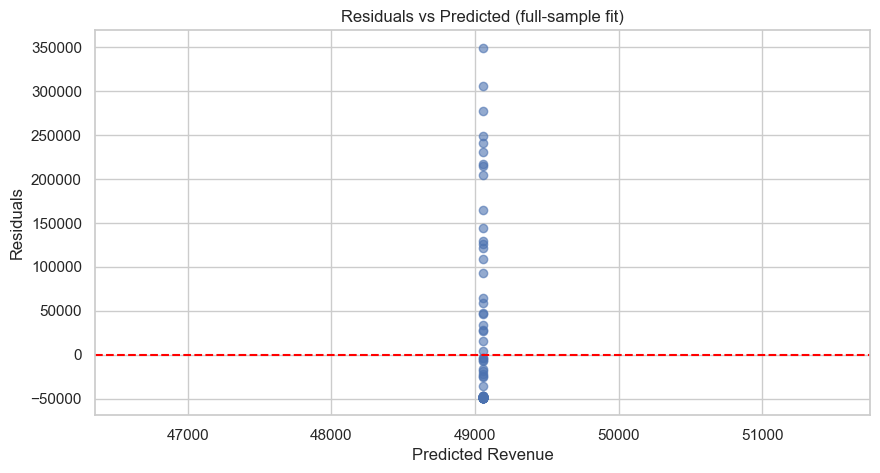

statsmodels not installed — skipping ACF plot


In [15]:
# Residual plot for full-sample fit of mediation model (if available)
if not df_feat.empty and med_results is not None and 'stage2' in med_results:
    X_full = df_feat[med_results['stage2']['features']].fillna(0.0)
    X_scaled = med_results['stage2']['scaler'].transform(X_full)
    preds = med_results['stage2']['model'].predict(X_scaled)
    residuals = df_feat['revenue'].values - preds

    plt.figure()
    plt.scatter(preds, residuals, alpha=0.6)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel('Predicted Revenue')
    plt.ylabel('Residuals')
    plt.title('Residuals vs Predicted (full-sample fit)')
    plt.show()

    # Autocorrelation of residuals
    try:
        import statsmodels.api as sm
        sm.graphics.tsa.plot_acf(residuals, lags=20)
        plt.title('ACF of residuals')
        plt.show()
    except Exception:
        print('statsmodels not installed — skipping ACF plot')
else:
    print('Skipping diagnostics — mediation results not available or data missing.')


## 8. Sensitivity checks
Example: test sensitivity to price change and promotions.

In [16]:
def sensitivity_price_promo(df: pd.DataFrame, med_results: Dict[str, Any], price_col: str = 'Price') -> pd.DataFrame:
    """Simulate revenue under a range of price and promotion scenarios using the stage2 model.

    Returns a DataFrame with scenario results.
    """
    base = df.copy()
    if med_results is None or 'stage2' not in med_results:
        raise ValueError('med_results must contain stage2 model')

    model = med_results['stage2']['model']
    scaler = med_results['stage2']['scaler']
    features = med_results['stage2']['features']

    if price_col in base.columns and base[price_col].notnull().any():
        prices = np.linspace(base[price_col].min() * 0.9, base[price_col].max() * 1.1, num=5)
    else:
        prices = np.linspace(0.9, 1.1, 5)
    promos = [0, 1] if 'Promotions' in base.columns else [0]

    rows = []
    for p in prices:
        for promo in promos:
            sim = base.copy()
            if price_col in sim.columns:
                sim['Price'] = p
            if 'Promotions' in sim.columns:
                sim['Promotions'] = promo

            X_sim = sim[features].fillna(0.0)
            X_sim_scaled = scaler.transform(X_sim)
            pred_rev = model.predict(X_sim_scaled)
            rows.append({'price': p, 'promotions': promo, 'mean_pred_revenue': float(pred_rev.mean())})

    return pd.DataFrame(rows)

if not df_feat.empty and med_results is not None:
    sens = sensitivity_price_promo(df_feat, med_results, price_col='Price')
    display(sens)
else:
    print('Skipping sensitivity — data or med_results missing')


,price,promotions,mean_pred_revenue
0,0.0,0,49053.945096
1,0.0,1,49053.945096
2,0.0,0,49053.945096
3,0.0,1,49053.945096
4,0.0,0,49053.945096
5,0.0,1,49053.945096
6,0.0,0,49053.945096
7,0.0,1,49053.945096
8,0.0,0,49053.945096
9,0.0,1,49053.945096


## 9. Save models and results
Save fitted models, scalers, and summary tables for reproducibility.

In [ ]:
import joblib

OUTPUT_DIR = 'D:\Assessment2\dataV1\mmm_outputs'
os.makedirs(OUTPUT_DIR, exist_ok=True)

if not df_feat.empty:
    # Save baseline and mediation models if they exist
    try:
        joblib.dump(baseline_result['model'], os.path.join(OUTPUT_DIR, 'baseline_ridge_model.joblib'))
        joblib.dump(baseline_result['scaler'], os.path.join(OUTPUT_DIR, 'baseline_scaler.joblib'))
    except Exception:
        pass

    try:
        if med_results is not None:
            joblib.dump(med_results['stage1']['model'], os.path.join(OUTPUT_DIR, 'mediator_stage1_model.joblib'))
            joblib.dump(med_results['stage2']['model'], os.path.join(OUTPUT_DIR, 'revenue_stage2_model.joblib'))
            joblib.dump(med_results['stage1']['scaler'], os.path.join(OUTPUT_DIR, 'mediator_scaler.joblib'))
            joblib.dump(med_results['stage2']['scaler'], os.path.join(OUTPUT_DIR, 'revenue_scaler.joblib'))
    except Exception:
        pass

print('Saved outputs to', OUTPUT_DIR)


Saved outputs to D:\Assessment2\data\mmm_outputs


## 10. Next steps & write-up tips

- Expand feature engineering: adstock for media channels, diminishing returns (log or power transforms), interaction terms.
- Try tree-based models and compare SHAP explanations for interpretability.
- For causal rigor: consider formal mediation analysis, instrumental variables if available, or structural equation modeling.

---

**Good luck!** Replace dataset path, run cells in order, and adapt column names as needed to match your data.